In [1]:
import os.path
import torch
from torch.utils.data import Dataset
import numpy
from tqdm import tqdm
from tqdm import trange
import multiprocessing
import math
import itertools
from torch_geometric.data import download_url
import torch_geometric.utils as pygutils
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES, MAX_NUM_CONSTRAINTS, NUM_PRIMITIVE_TYPES
# You have to import sketchgraphs this way otherwise you get type errors
os.chdir('SketchGraphs/')
import sketchgraphs.data as datalib
from sketchgraphs.data import flat_array
from sketchgraphs.data._entity import Point, Line, Circle, Arc, EntityType
from sketchgraphs.data.sketch import Sketch
from sketchgraphs.data._constraint import *
os.chdir('../')

In [ ]:
def transform(data):
    # Pad node feature matrix to have maximum 24 nodes
    # x = data.nodes.to_dense()
    # nodes = torch.zeros(size = (MAX_NUM_PRIMITIVES, NODE_FEATURE_DIMENSION))
    # num_primitives = len(x)
    # nodes[:num_primitives] = x
    # nodes[num_primitives:] = torch.tensor([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    # Convert sparse edge feature tensor to dense tensor
    # edges = data.edges.to_dense()
    # edges[torch.abs(edges).sum(dim = 2) == 0] = torch.Tensor([0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1])
    # Convert sparse node parameter mask to dense tensor
    # node_params_mask = data.node_params_mask.to_dense()
    return data[0], data[1], SketchDataset.params_mask(data[0])

In [7]:
class SketchDataset(Dataset):
    def __init__(self, root):
        self.raw_dir = os.path.join(root, "raw/")
        self.processed_dir = os.path.join(root, "processed/")
        
        if not os.path.exists(os.path.join(self.raw_dir, 'sg_t16_train.npy')):
            self.download()
        if not os.path.exists(os.path.join(self.raw_dir, 'sg_t16_validation.npy')):
            self.download()
        if not os.path.exists(os.path.join(self.raw_dir, 'sg_t16_test.npy')):
            self.download()
            
        nodes_file_path = os.path.join(self.processed_dir, "nodes1.pt")
        edges_file_path = os.path.join(self.processed_dir, "edges1.pt")
        
        isProcessed = os.path.exists(nodes_file_path) and os.path.exists(edges_file_path)
        
        os.makedirs( name = self.processed_dir, exist_ok = True )
        
        if not isProcessed:
            self.process()
        
        self.nodes = torch.load(os.path.join(self.processed_dir, 'nodes1.pt'))
        self.edges = torch.load(os.path.join(self.processed_dir, 'edges1.pt'))
        
    @property
    def raw_file_names(self):
        return ['sg_t16_train.npy', 'sg_t16_validation.npy', 'sg_t16_test.npy']
    
    @property 
    def processed_file_names(self):
        return ["nodes1.npy","edges1.npy"]
    
    @property
    def num_node_features(self):
        return NODE_FEATURE_DIMENSION
    
    @property
    def num_edge_features(self):
        return EDGE_FEATURE_DIMENSION
    
    def download(self):
        path = download_url(url = "https://sketchgraphs.cs.princeton.edu/sequence/sg_t16_train.npy", 
                            folder = self.raw_dir
                           );
        path = download_url(url = "https://sketchgraphs.cs.princeton.edu/sequence/sg_t16_validation.npy", 
                            folder = self.raw_dir
                           );
        path = download_url(url = "https://sketchgraphs.cs.princeton.edu/sequence/sg_t16_test.npy", 
                            folder = self.raw_dir
                           );
        # print("Downloaded SketchGraphs dataset to " + path)

    def process(self):
        save_nodes = torch.zeros(2127996, MAX_NUM_PRIMITIVES, NODE_FEATURE_DIMENSION)
        save_edges = torch.zeros(2127996, MAX_NUM_PRIMITIVES, MAX_NUM_PRIMITIVES, EDGE_FEATURE_DIMENSION)
        # Change dir to SketchGraphs so module not found error doesn't popup
        os.chdir('SketchGraphs/')
        # Load SketchGraphs sequence data dictionary
        seq_train_data = flat_array.load_dictionary_flat(os.path.join("../", self.raw_dir, 'sg_t16_train.npy'))
        seq_validation_data = flat_array.load_dictionary_flat(os.path.join("../", self.raw_dir, 'sg_t16_validation.npy'))
        seq_test_data = flat_array.load_dictionary_flat(os.path.join("../", self.raw_dir, 'sg_t16_test.npy'))
        sequences = itertools.chain(seq_train_data["sequences"], seq_validation_data["sequences"], seq_test_data["sequences"])
        idx = 0
        #save_nodes = torch.zeros([128,MAX_NUM_PRIMITIVES,NODE_FEATURE_DIMENSION])
        #save_edges = torch.zeros([128,MAX_NUM_PRIMITIVES,MAX_NUM_PRIMITIVES,EDGE_FEATURE_DIMENSION])
        #save_node_params_masks = torch.zeros([128,MAX_NUM_PRIMITIVES,NODE_FEATURE_DIMENSION - 6])
        for _ in tqdm(range(len(seq_train_data["sequences"]) + len(seq_validation_data["sequences"]) + len(seq_test_data["sequences"]))):
            seq = next(sequences)
            sketch = datalib.sketch_from_sequence(seq)
            # Remove invalid sketches
            if sketch is None:
                continue
            # Filter out sketches with less than 7 or more than 24 primitives
            # or less constraints than primitives or more than 208 constraints
            if len(sketch.entities) < 7 or len(sketch.entities) > 24 or len(sketch.constraints) < len(sketch.entities) or len(sketch.constraints) > 208:
                continue
            # Construct Data Object containing graph
            node_features, adjacency_list, edge_features = SketchDataset.sketch_to_graph(sketch)
            
            # Normalize node paramter values (except arc startParam and endParam) to be in range [-10, 10]
            val_indices = [6,7,8,9,10,11,12,13,14,15,18,19]
            node_features[:,val_indices] = node_features[:,val_indices] / torch.max(torch.abs(node_features[:,val_indices]))
            
            if (not node_features.isfinite().all()):
                continue
            if (not adjacency_list.isfinite().all()):
                continue
            if (not edge_features.isfinite().all()):
                continue
                
            # Add arguments to data
            nodes = torch.zeros(size = (MAX_NUM_PRIMITIVES, NODE_FEATURE_DIMENSION))
            num_primitives = len(node_features)
            nodes[:num_primitives] = node_features
            nodes[num_primitives:] = torch.tensor([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
            
            edges = torch.sparse_coo_tensor(adjacency_list, edge_features, (
                MAX_NUM_PRIMITIVES, 
                MAX_NUM_PRIMITIVES, 
                EDGE_FEATURE_DIMENSION)).to_dense()
            edges[torch.abs(edges).sum(dim = 2) == 0] = torch.Tensor([0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1])
            
            save_nodes[idx] = nodes
            save_edges[idx] = edges
            
            idx += 1
        # Save file flag and Change dir back
        # open(os.path.join("../", self.processed_dir, 'finished_processing'), 'a').close()
        os.chdir('../')
        torch.save(save_nodes, os.path.join(self.processed_dir, 'nodes1.pt'))
        torch.save(save_edges, os.path.join(self.processed_dir, 'edges1.pt'))
        print("Saved Graphs: ", idx)
        
    @staticmethod
    def sketch_to_graph(sketch):
        # Setup output data structures
        num_nodes = len(sketch.entities)
        num_edges = len(sketch.constraints)
        # Node feature matrix
        node_matrix = torch.zeros(size=(num_nodes if num_nodes < MAX_NUM_PRIMITIVES else MAX_NUM_PRIMITIVES, NODE_FEATURE_DIMENSION));
        # Adjacency matrix
        edge_index = torch.zeros(size=(num_edges if num_edges < MAX_NUM_CONSTRAINTS else MAX_NUM_CONSTRAINTS, 2));
        # Edge feature matrix
        edge_attr = torch.zeros(size=(num_edges if num_edges < MAX_NUM_CONSTRAINTS else MAX_NUM_CONSTRAINTS, EDGE_FEATURE_DIMENSION));
        # Build node feature matrix according to the schema outlined in paper
        idx = 0;
        node_ref_to_idx = {};
        for key, value in sketch.entities.items():
            # Enforce maximum 24 primitives limit
            if (idx == MAX_NUM_PRIMITIVES):
                break
            
            node_feature = torch.zeros(20);
            node_ref_to_idx[key] = idx;
            node_feature[0] = int(value.isConstruction);
            match value.type:
                case EntityType.Line:
                    node_feature[1] = 1;
                    node_feature[6:8] = torch.from_numpy(value.start_point);
                    node_feature[8:10] = torch.from_numpy(value.end_point);
                case EntityType.Circle:
                    node_feature[2] = 1;
                    node_feature[10:12] = torch.from_numpy(value.center_point);
                    node_feature[12] = value.radius;
                case EntityType.Arc:
                    node_feature[3] = 1;
                    node_feature[13:15] = torch.from_numpy(value.center_point);
                    node_feature[15] = value.radius;
                    angle_start_offset = value.endParam if value.clockwise else value.startParam;
                    angle_end_offset = value.startParam if value.clockwise else value.endParam;
                    angle = math.atan2(value.yDir, value.xDir);
                    node_feature[16] = ((angle + angle_start_offset) % (2*math.pi)) / (2*math.pi)
                    node_feature[17] = ((angle + angle_end_offset) % (2*math.pi)) / (2*math.pi)
                case EntityType.Point:
                    node_feature[4] = 1;
                    node_feature[18] = value.x;
                    node_feature[19] = value.y;
                case _:
                    continue
                
            node_matrix[idx] = node_feature
            idx += 1
        # Remove all unused entries before returning, since there are a variable number of relevant primitives per sketch
        node_matrix = node_matrix[:idx]
        # Build adjacency list and edge feature matrix
        idx = 0;
        edge_exists = {}
        for value in sketch.constraints.values():
            # Enforce maximum 208 constraints limit
            if (idx == MAX_NUM_CONSTRAINTS):
                break
            edge_feature = torch.zeros(17);
            # Set one hot encoding for constraint type
            match value.type:
                case ConstraintType.Coincident:
                    edge_feature[8] = 1;
                case ConstraintType.Horizontal:
                    edge_feature[9] = 1;
                case ConstraintType.Vertical:
                    edge_feature[10] = 1;
                case ConstraintType.Parallel:
                    edge_feature[11] = 1;
                case ConstraintType.Perpendicular:
                    edge_feature[12] = 1;
                case ConstraintType.Tangent:
                    edge_feature[13] = 1;
                case ConstraintType.Midpoint:
                    edge_feature[14] = 1;
                case ConstraintType.Equal:
                    edge_feature[15] = 1;
                case _:
                    continue;
            connection = value.get_references()
            node_a_ref = connection[0].split('.')
            # Constraint references irrelevant primitive -----
            if node_a_ref[0] not in node_ref_to_idx:
                continue
            node_a_idx = node_ref_to_idx[node_a_ref[0]]
            # Add one hot encoding for where the constraint is applied for primitive
            if len(node_a_ref) == 2:
                    match node_a_ref[1]:
                        case "start":
                            edge_feature[0] = 1
                        case "center":
                            edge_feature[1] = 1
                        case "end":
                            edge_feature[2] = 1
            else:
                edge_feature[3] = 1
            # If constraint only applies to 1 primitive
            if len(connection) == 1:
                # Multi graphs are not supported -----
                if (node_a_idx, node_a_idx) in edge_exists:
                    continue
                # Add a self loop on node
                edge_index[idx] = torch.tensor([node_a_idx, node_a_idx])
                edge_exists[(node_a_idx, node_a_idx)] = True
                # Save edge feature vector
                edge_feature[7] = 1 # constraint is not applied for another primitive
                edge_attr[idx] = edge_feature
                idx += 1
                continue
            # If constraint applies to 2 primitives
            node_b_ref = connection[1].split('.')
            # Constraint references irrelevant primitive -----
            if node_b_ref[0] not in node_ref_to_idx:
                continue
            node_b_idx = node_ref_to_idx[node_b_ref[0]]
            # Add one hot encoding for where the constraint is applied for second primitive
            if len(node_b_ref) == 2:
                match node_b_ref[1]:
                    case "start":
                        edge_feature[4] = 1
                    case "center":
                        edge_feature[5] = 1
                    case "end":
                        edge_feature[6] = 1
            else:
                edge_feature[7] = 1
            # Multi graphs are not supported -----
            if (node_a_idx, node_b_idx) in edge_exists:
                continue
            # Add an edge between the 2 nodes
            edge_index[idx] = torch.tensor([node_a_idx, node_b_idx])
            edge_exists[(node_a_idx, node_b_idx)] = True
            # Save edge feature vector
            edge_attr[idx] = edge_feature
            idx += 1
        # Remove all unused adjacency info since there are a variable number of relevant constraints per sketch
        edge_index = edge_index[:idx]
        edge_attr = edge_attr[:idx]
        return node_matrix, edge_index.T.contiguous(), edge_attr

    @staticmethod
    def graph_to_sketch(node_matrix, edge_index, edge_attr):
        sketch = Sketch()
        # Add entities
        for idx in range(len(node_matrix)):
            entity = node_matrix[idx]
            match torch.argmax(entity[1:5]):
                case 0:
                    # Create Line
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    pnt = entity[6:8]
                    startParam = 0
                    dir = (entity[8:10] - entity[6:8]) / torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                    endParam = torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                    line = Line(entityId = id,
                                isConstruction = isConstructible, 
                                pntX = pnt[0], 
                                pntY = pnt[1], 
                                dirX = dir[0], 
                                dirY = dir[1], 
                                startParam = startParam, 
                                endParam = endParam
                               );
                    sketch.entities[id] = line
                case 1:
                    # Create Circle
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    center = entity[10:12]
                    radius = entity[12]
                    circle = Circle(entityId = id, 
                                  isConstruction = isConstructible, 
                                  xCenter = center[0], 
                                  yCenter = center[1], 
                                  xDir = 1, 
                                  yDir = 0, 
                                  radius = radius, 
                                  clockwise = False
                                 );
                    sketch.entities[id] = circle
                case 2: 
                    # Create Arc
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    center = entity[13:15]
                    radius = entity[15]
                    startParam = entity[16] * (2*math.pi)
                    endParam = entity[17] * (2*math.pi)
                    arc = Arc(entityId = id, 
                              isConstruction = isConstructible, 
                              xCenter = center[0], 
                              yCenter = center[1], 
                              xDir = 1, 
                              yDir = 0,
                              radius = radius, 
                              startParam = startParam,
                              endParam = endParam, 
                              clockwise = False
                             );
                    sketch.entities[id] = arc
                case 3:
                    # Create Point
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    x = entity[18]
                    y = entity[19]
                    point = Point(entityId = id, 
                                  isConstruction = isConstructible,
                                  x = x,
                                  y = y
                                 );
                    sketch.entities[id] = point
        # Add constraints
        for idx in range(len(edge_attr)):
            constraint = edge_attr[idx]
            identifier = "c_" + str(idx)
            constraintType = ConstraintType.Coincident # Initial Value
            param_ids = None
            params = []
            # Convert one hot encoding to constraint label
            match torch.argmax(constraint[8:17]):
                case 0:
                    # Coincident
                    constraintType = ConstraintType.Coincident
                case 1:
                    # Horizontal
                    constraintType = ConstraintType.Horizontal
                case 2:
                    # Vertical
                    constraintType = ConstraintType.Vertical
                case 3:
                    # Parallel
                    constraintType = ConstraintType.Parallel
                case 4:
                    # Perpendicular
                    constraintType = ConstraintType.Perpendicular
                case 5:
                    # Tangent
                    constraintType = ConstraintType.Tangent
                case 6:
                    # Midpoint
                    constraintType = ConstraintType.Midpoint
                case 7:
                    # Equal
                    constraintType = ConstraintType.Equal
                case _:
                    # None
                    continue
            # Adjust reference parameter ids if necessary
            if constraintType == ConstraintType.Midpoint:
                param_ids = ['local0', 'local1']
            else:
                param_ids = ['localFirst', 'localSecond']
            edge = edge_index.T[idx]
            if torch.equal(edge[0], edge[1]):
                # Constraint only applies to single entity
                node_ref = str(edge[0])
                match torch.argmax(constraint[0:4]):
                    case 0:
                        node_ref = node_ref + ".start"
                    case 1:
                        node_ref = node_ref + ".center"
                    case 2:
                        node_ref = node_ref + ".end"
                param1 = LocalReferenceParameter(param_ids[0], node_ref)
                params.append(param1)
            else:
                # Constraint applies to 2 primitives
                node_a_ref = str(edge[0])
                match torch.argmax(constraint[0:4]):
                    case 0:
                        node_ref = node_a_ref + ".start"
                    case 1:
                        node_ref = node_a_ref + ".center"
                    case 2:
                        node_ref = node_a_ref + ".end"
                node_b_ref = str(edge[1])
                match torch.argmax(constraint[4:8]):
                    case 0:
                        node_ref = node_b_ref + ".start"
                    case 1:
                        node_ref = node_b_ref + ".center"
                    case 2:
                        node_ref = node_b_ref + ".end"
                param1 = LocalReferenceParameter(param_ids[0], node_a_ref)
                params.append(param1)
                param2 = LocalReferenceParameter(param_ids[1], node_b_ref)
                params.append(param2)
            sketch.constraints[identifier] = Constraint(identifier, constraintType, params)
        return sketch

    @staticmethod
    def preds_to_sketch(nodes, edges):
        sketch = Sketch()
        # Add entities
        for idx in range(len(nodes)):
            entity = nodes[idx]
            match torch.argmax(entity[1:6]):
                case 0:
                    # Create Line
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    pnt = entity[6:8]
                    startParam = 0
                    dir = (entity[8:10] - entity[6:8]) / torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                    endParam = torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                    line = Line(entityId = id,
                                isConstruction = isConstructible, 
                                pntX = pnt[0], 
                                pntY = pnt[1], 
                                dirX = dir[0], 
                                dirY = dir[1], 
                                startParam = startParam, 
                                endParam = endParam
                               );
                    sketch.entities[id] = line
                case 1:
                    # Create Circle
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    center = entity[10:12]
                    radius = entity[12]
                    circle = Circle(entityId = id, 
                                  isConstruction = isConstructible, 
                                  xCenter = center[0], 
                                  yCenter = center[1], 
                                  xDir = 1, 
                                  yDir = 0, 
                                  radius = radius, 
                                  clockwise = False
                                 );
                    sketch.entities[id] = circle
                case 2: 
                    # Create Arc
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    center = entity[13:15]
                    radius = entity[15]
                    startParam = entity[16] * (2*math.pi)
                    endParam = entity[17] * (2*math.pi)
                    arc = Arc(entityId = id, 
                              isConstruction = isConstructible, 
                              xCenter = center[0], 
                              yCenter = center[1], 
                              xDir = 1, 
                              yDir = 0,
                              radius = radius, 
                              startParam = startParam,
                              endParam = endParam, 
                              clockwise = False
                             );
                    sketch.entities[id] = arc
                case 3:
                    # Create Point
                    id = str(idx + 1)
                    isConstructible = bool(entity[0])
                    x = entity[18]
                    y = entity[19]
                    point = Point(entityId = id, 
                                  isConstruction = isConstructible,
                                  x = x,
                                  y = y
                                 );
                    sketch.entities[id] = point
                case _:
                    continue

        # Add constraints
        idx = 0
        for i in range(edges.size(0)):
            for j in range(edges.size(1)):
                constraint = edges[i][j]
                identifier = "c_" + str(idx)
                constraintType = ConstraintType.Coincident # Initial Value
                param_ids = None
                params = []
                # Convert one hot encoding to constraint label
                match torch.argmax(constraint[8:17]):
                    case 0:
                        # Coincident
                        constraintType = ConstraintType.Coincident
                    case 1:
                        # Horizontal
                        constraintType = ConstraintType.Horizontal
                    case 2:
                        # Vertical
                        constraintType = ConstraintType.Vertical
                    case 3:
                        # Parallel
                        constraintType = ConstraintType.Parallel
                    case 4:
                        # Perpendicular
                        constraintType = ConstraintType.Perpendicular
                    case 5:
                        # Tangent
                        constraintType = ConstraintType.Tangent
                    case 6:
                        # Midpoint
                        constraintType = ConstraintType.Midpoint
                    case 7:
                        # Equal
                        constraintType = ConstraintType.Equal
                    case _:
                        # None
                        continue
                # Adjust reference parameter ids if necessary
                if constraintType == ConstraintType.Midpoint:
                    param_ids = ['local0', 'local1']
                else:
                    param_ids = ['localFirst', 'localSecond']
                edge = torch.Tensor([i, j])
                if torch.equal(edge[0], edge[1]):
                    # Constraint only applies to single entity
                    node_ref = str(edge[0])
                    match torch.argmax(constraint[0:4]):
                        case 0:
                            node_ref = node_ref + ".start"
                        case 1:
                            node_ref = node_ref + ".center"
                        case 2:
                            node_ref = node_ref + ".end"
                    param1 = LocalReferenceParameter(param_ids[0], node_ref)
                    params.append(param1)
                else:
                    # Constraint applies to 2 primitives
                    node_a_ref = str(edge[0])
                    match torch.argmax(constraint[0:4]):
                        case 0:
                            node_ref = node_a_ref + ".start"
                        case 1:
                            node_ref = node_a_ref + ".center"
                        case 2:
                            node_ref = node_a_ref + ".end"
                    node_b_ref = str(edge[1])
                    match torch.argmax(constraint[4:8]):
                        case 0:
                            node_ref = node_b_ref + ".start"
                        case 1:
                            node_ref = node_b_ref + ".center"
                        case 2:
                            node_ref = node_b_ref + ".end"
                    param1 = LocalReferenceParameter(param_ids[0], node_a_ref)
                    params.append(param1)
                    param2 = LocalReferenceParameter(param_ids[1], node_b_ref)
                    params.append(param2)
                sketch.constraints[identifier] = Constraint(identifier, constraintType, params)
                idx = idx + 1
        return sketch
    
    @staticmethod
    def params_mask(nodes):
        mask = torch.zeros(size = (MAX_NUM_PRIMITIVES, NODE_FEATURE_DIMENSION - NUM_PRIMITIVE_TYPES - 1))
        i = 0
        for node in nodes:
            match torch.argmax(node[1:6]):
                case 0:
                    # Line
                    mask[i][0:4] = 1
                case 1:
                    # Circle
                    mask[i][4:7] = 1
                case 2:
                    # Arc
                    mask[i][7:12] = 1
                case 3:
                    # Point
                    mask[i][12:] = 1
            i = i + 1
        return mask

    @staticmethod
    def sort_graph(node_matrix, adjacency_list):
        # Helper variables
        num_nodes = len(node_matrix)
        node_out_degrees = pygutils.degree(adjacency_list.long()[0], num_nodes)
        # Generate permutation indices to sort graph
        indices = range(num_nodes)
        node_permutation_indices = sorted(  indices, key = lambda idx: (  node_matrix[idx].tolist() + [node_out_degrees[idx]]  )  )
        # return sorted node feature matrix and adjacency list
        sorted_node_matrix = node_matrix[node_permutation_indices]
        node_oldidx_to_newidx = [node_permutation_indices.index(value) for value in range(len(node_permutation_indices))]
        updated_adjacency_list = torch.Tensor(node_oldidx_to_newidx)[adjacency_list.long()]
        return sorted_node_matrix, updated_adjacency_list
    
    def __len__(self):
        # The minus two is there because pre_transform.pt and pre_filter.pt are also included in processed_file_names
        return 3981513
    
    def __getitem__(self, idx):
        # For whatever reason there is a limit of ~3 million files/sub directories per directory on my university's nfs share, 
        # so ~4.4 million data files are partitioned into ~88 subdirectories containing atmost 50,000 data files each
        
        return self.nodes[idx], self.edges[idx], SketchDataset.params_mask(self.nodes[idx])

In [8]:
dataset = SketchDataset(root = "data/")

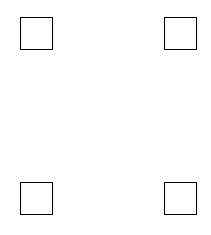

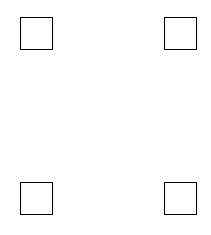

In [110]:
nodes, edges, params_mask = dataset[101]
sketch = SketchDataset.preds_to_sketch(nodes, edges)
datalib.render_sketch(sketch)

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from loss import reconstruction_loss

dset = TensorDataset(dataset.nodes, dataset.edges)
loader = DataLoader(dataset = dset, batch_size = 784)

for nodes, edges in tqdm(loader):
    nodes = nodes.to('cuda')
    edges = edges.to('cuda')
    reconstruction_loss(nodes, edges, nodes, edges)
    # node_params_mask = node_params_mask.to('cuda')

100%|███████████████████████████████████████| 5079/5079 [03:09<00:00, 26.82it/s]


In [5]:
def load_data(idx):
    return dataset[idx]

In [6]:
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor() as executor:
    data = executor.map(load_data, range(len(dataset)))

In [6]:
dataset[3981512]

(tensor([[ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7500, -1.0000,
          -0.7500, -1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7500,  1.0000,
          -0.7500,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7500, -1.0000,
           0.7500,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7500, -1.0000,
          -0.7500,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

In [8]:
from model import GVAE
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [9]:
dataset = SketchDataset(root="data/")

generator = torch.Generator().manual_seed(4)
train_set, validate_set, test_set = random_split(dataset = dataset, lengths = [0.9, 0.033, 0.067], generator = generator)

print("Number of Graphs in total: ", dataset.len())
print("Number of Graphs for training: ", len(train_set))
print("Number of Graphs for validation: ", len(validate_set))
print("Number of Graphs for testing: ", len(test_set))

Number of Graphs in total:  4461654
Number of Graphs for training:  4015489
Number of Graphs for validation:  147235
Number of Graphs for testing:  298930


In [14]:
batch_size = 512
learning_rate = 1e-3
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, persistent_workers = True, num_workers = 8, pin_memory = True)
validate_loader = DataLoader(dataset = validate_set, batch_size = batch_size, persistent_workers = True, num_workers = 8, pin_memory = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, persistent_workers = True, num_workers = 8, pin_memory = True)

In [18]:
for batch_index, (nodes, edges, node_params_mask) in enumerate(validate_loader):
    nodes = nodes.to(device)
    edges = edges.to(device)
    node_params_mask = node_params_mask.to(device)
    print(batch_index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
os.chdir('SketchGraphs/')
# Load SketchGraphs sequence data dictionary
seq_data = flat_array.load_dictionary_flat('../data/raw/sg_all.npy')
sequences = seq_data["sequences"]
seq = sequences[1710157]
sketch = datalib.sketch_from_sequence(seq)

os.chdir('../')

NodeOp(label=<EntityType.External: 7>, parameters={})
NodeOp(label=<EntityType.Point: 0>, parameters={'isConstruction': False, 'x': 0.0, 'y': 0.0})
EdgeOp(label=<ConstraintType.Projected: 1>, references=(1, 0), parameters={})
NodeOp(label=<EntityType.Line: 1>, parameters={'isConstruction': False, 'dirX': 1.0, 'dirY': 0.0, 'pntX': 0.00921805202960968, 'pntY': 0.0, 'startParam': -0.00921805202960968, 'endParam': 0.00921805202960968})
NodeOp(label=<SubnodeType.SN_Start: 101>, parameters={})
EdgeOp(label=<ConstraintType.Subnode: 101>, references=(3, 2), parameters={})
EdgeOp(label=<ConstraintType.Coincident: 0>, references=(3, 1), parameters={})
NodeOp(label=<SubnodeType.SN_End: 102>, parameters={})
EdgeOp(label=<ConstraintType.Subnode: 101>, references=(4, 2), parameters={})
NodeOp(label=<EntityType.Line: 1>, parameters={'isConstruction': False, 'dirX': 1.0, 'dirY': 0.0, 'pntX': 0.00921805202960968, 'pntY': -0.01657174527645111, 'startParam': -0.00921805202960968, 'endParam': 0.0092180520